In [1]:
%cd ..

c:\Users\nata0\c3


C:\Users\nata0\AppData\Roaming\Python\Python310\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import os
import numpy as np
import pandas as pd
import swifter
import matplotlib.pyplot as plt
import japanize_matplotlib

from src.util import make_player_df_from_playdf, norm_xy_to_gfootball
from src.real_data import make_scenario_from_real_data

pd.set_option("display.max_columns", None)
# pd.set_option('display.max_rows', None)

c:\Users\nata0\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_dir = "data/unofficial/2023041506"
p_play = os.path.join(data_dir, "play.csv")
p_tracking = os.path.join(data_dir, "tracking.csv")
play_df = pd.read_csv(p_play, encoding="ansi")
tracking_df = pd.read_csv(p_tracking)

player_df = make_player_df_from_playdf(play_df)
tracking_df[["norm_X", "norm_Y"]] = tracking_df.swifter.apply(
    lambda row: pd.Series(norm_xy_to_gfootball(row["X"], row["Y"])), axis=1
)
tracking_df = tracking_df.merge(
    player_df[["ホームアウェイF", "選手背番号", "ポジション"]],
    left_on=["HA", "No"],
    right_on=["ホームアウェイF", "選手背番号"],
    how="left",
)

Dask Apply: 100%|██████████| 57/57 [00:09<00:00,  5.90it/s]


In [4]:
player_df

,ホームアウェイF,選手背番号,ポジションID,選手名,ポジション
0,1,29,1,早川 友基,GK
1,1,55,2,植田 直通,DF
2,1,22,2,広瀬 陸斗,DF
3,1,2,2,安西 幸輝,DF
4,1,5,2,関川 郁万,DF
5,1,10,3,荒木 遼太郎,MF
6,1,21,3,ディエゴ ピトゥカ,MF
7,1,14,3,樋口 雄太,MF
8,1,40,4,鈴木 優磨,FW
9,1,27,4,松村 優太,FW


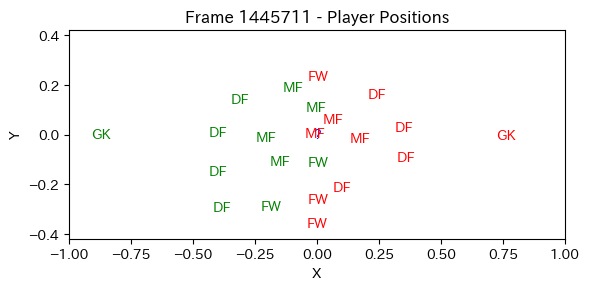

In [5]:
import matplotlib.pyplot as plt

# 色マッピング
cmap = {0: "b", 1: "r", 2: "g"}  # Ball  # Home team  # Away team

# 特定フレームのデータ抽出
ini_frame = int(tracking_df.loc[tracking_df["No"] == 0, "Frame"].iloc[0])
tracking_framedf = tracking_df.loc[tracking_df["Frame"] == ini_frame]

# 描画準備
fig, ax = plt.subplots()
ax.set_aspect("equal")

# 各行に対して、X, Y 座標にポジション名を描画
for _, row in tracking_framedf.iterrows():
    color = cmap.get(row["HA"], "k")  # 万が一未定義のカテゴリがあれば黒に
    label = row["ポジション"] if pd.notna(row["ポジション"]) else "?"
    ax.text(
        row["norm_X"],
        row["norm_Y"],
        label,
        color=color,
        fontsize=10,
        ha="center",
        va="center",
    )

# 軸ラベル・タイトルなど任意で追加
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_xlim(-1, 1)
ax.set_ylim(-0.42, 0.42)
ax.set_title(f"Frame {ini_frame} - Player Positions")

plt.show()

In [6]:
position_to_gfootball_role_dict = {
    "GK": "e_PlayerRole_GK",
    "DF": "e_PlayerRole_CB ",
    "MF": "e_PlayerRole_DM ",
    "FW": "e_PlayerRole_CF ",
}

tracking_framedf["gfootball_role"] = tracking_framedf["ポジション"].map(
    position_to_gfootball_role_dict
)

C:\Users\nata0\AppData\Local\Temp\ipykernel_20900\2586761319.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracking_framedf["gfootball_role"] = tracking_framedf["ポジション"].map(position_to_gfootball_role_dict)


In [7]:
scenario_file = make_scenario_from_real_data(tracking_framedf)

scenario_path = "scenarios/from_real_soccer_data.py"
with open(scenario_path, "w", encoding="utf-8") as f:
    f.write(scenario_file)